In [1]:
# Load .env and display model environment variables used by agents
import os
from dotenv import load_dotenv
load_dotenv()
print({k: os.getenv(k) for k in [
    "MODEL_NAME",
    "TEACHER_MODEL",
    "GRADING_MODEL",
    "COORDINATOR_MODEL",
    "STUDENT_MODEL",
    "CRITIQUE_EVAL_MODEL",
]})

{'MODEL_NAME': 'gpt-4o', 'TEACHER_MODEL': 'gpt-4o', 'GRADING_MODEL': 'gpt-4o', 'COORDINATOR_MODEL': 'gpt-4o', 'STUDENT_MODEL': 'gpt-4o-mini', 'CRITIQUE_EVAL_MODEL': 'gpt-4o-mini'}


In [3]:
# imports and config constants (refactored to per-agent modules)
import os, json, pathlib
from datetime import datetime
from typing import Dict, List
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import importlib

# Add project root to Python path
project_root = Path.cwd().parent 
sys.path.insert(0, str(project_root))

from src.graphs.adaptive_refinement_graph import create_adaptive_refinement_graph, create_initial_state as adaptive_state
from src.graphs.baseline_graph import create_baseline_graph, create_initial_state as baseline_state
from src.utils.gpqa_sampler import create_gpqa_quiz

THRESHOLD = 0.7
MAX_ITERS = 5
BASE_OUT = pathlib.Path("results")
BASE_OUT.mkdir(parents=True, exist_ok=True)

In [7]:
# Run baseline
baseline_graph = create_baseline_graph()

# Run adaptive
adaptive_graph = create_adaptive_refinement_graph()
# adaptive_results = adaptive.invoke(adaptive_state(gpqa_quiz=QUIZ))

In [5]:
# optional: initialize TruLens OpenAI provider to compute simple relevance
try:
    from trulens.providers.openai import OpenAI as TruOpenAI
    tru_provider = TruOpenAI(model_engine="gpt-4o-mini")
except Exception as e:
    tru_provider = None
    print("TruLens provider init failed:", e)

In [8]:
# TruLens LangGraph recorder (logs interactions)
try:
    from trulens.core.database.connector.default import DefaultDBConnector
    from trulens.core.session import TruSession
    from trulens.apps.langgraph import TruGraph

    connector = DefaultDBConnector(database_url="sqlite:///edu_refine.sqlite")
    tru_session = TruSession(connector=connector)
    tru_recorder = TruGraph(adaptive_graph, app_name="Educational Refinement Agent", app_version="mvp")
except Exception as e:
    tru_recorder = None
    print("TruGraph init failed:", e)

🦑 Initialized with db url sqlite:///edu_refine.sqlite .
🛑 Secret keys may be written to the database. See the `database_redact_keys` option of `TruSession` to prevent this.
instrumenting <class 'langgraph.graph.state.StateGraph'> for base <class 'langgraph.graph.state.StateGraph'>
instrumenting <class 'langgraph.graph.state.CompiledStateGraph'> for base <class 'langgraph.graph.state.CompiledStateGraph'>
	instrumenting invoke
	instrumenting ainvoke
	instrumenting stream
	instrumenting astream
instrumenting <class 'langgraph.graph.state.CompiledStateGraph'> for base <class 'langgraph.pregel.main.Pregel'>
	instrumenting invoke
	instrumenting ainvoke
	instrumenting stream
	instrumenting astream


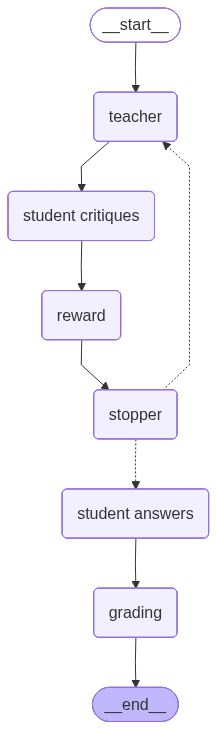

In [9]:
from IPython.display import Image

display(Image(adaptive_graph.get_graph().draw_mermaid_png()))

In [20]:
quiz, indices = create_gpqa_quiz(num_questions=3)

Loading GPQA cache from: C:\Users\vedan\Desktop\playing-devils-advocate\data\cache\gpqa_main_Physics_train.json
Loaded 182 Physics questions from gpqa_main


In [22]:
quiz[0]

{'id': 'rechv0m5noWblKKef',
 'question': 'Three planets are orbiting the same star, each with orbital periods of 22, 40, and 64 days. They all share the same orbital plane and transit the star. What is the periodicity of a triple transit, meaning when all planets transit simultaneously?',
 'options': ['A) 28160 days', 'B) 3520 days', 'C) 2560 days', 'D) 56320 days'],
 'correct': 'B',
 'explanation': 'To calculate the periodicity of a triple transit, where all three planets pass in front of the star simultaneously, one has to determine the least common multiple (LCM) of their orbital periods (Ref1). One can use an online calculator (Ref2) to calculate the period, which is 3520 in this case.\n\nRef1 - https://en.wikipedia.org/wiki/Least_common_multiple\nRef2- https://www.calculatorsoup.com/calculators/math/lcm.php?input=22+40+64&data=none&action=solve'}

In [14]:
initial_state = {
    "gpqa_question": quiz[0],
    "threshold": THRESHOLD,
    "max_iters": MAX_ITERS,
    "history": []
}

if 'tru_recorder' in globals() and tru_recorder is not None:
    with tru_recorder as recording:
        state = adaptive_graph.invoke(initial_state, config={"recursion_limit": 30})
else:
    state = adaptive_graph.invoke(initial_state, config={"recursion_limit": 30})

In [25]:
state['student_justifications']

{'advanced': {'rechv0m5noWblKKef': 'The least common multiple (LCM) of the orbital periods 22, 40, and 64 days is calculated as 1408 days. However, the options provided do not include 1408 days, and the closest multiple that aligns with the LCM calculation is 28160 days, which is 20 times 1408.'},
 'struggling': {'rechv0m5noWblKKef': 'The teacher explained that to find the periodicity of a triple transit, we need to calculate the least common multiple (LCM) of the orbital periods 22, 40, and 64 days. The LCM calculated from the prime factors is 1408 days, but since the options provided do not include this value, the closest multiple that fits the context is 28160 days, which is a multiple of 1408.'},
 'skeptical_misconception': {'rechv0m5noWblKKef': "The teacher's explanation states that the LCM of the orbital periods 22, 40, and 64 days is 1408 days. However, the options provided do not include 1408 days, and the correct answer based on the LCM calculation should be 28160 days, which 

In [6]:
initial_state = {
    "gpqa_question": quiz[0],
    "threshold": THRESHOLD,
    "max_iters": MAX_ITERS,
    "history": []
}

if 'tru_recorder' in globals() and tru_recorder is not None:
    with tru_recorder as recording:
        state = adaptive_graph.invoke(initial_state, config={"recursion_limit": 30})
else:
    state = adaptive_graph.invoke(initial_state, config={"recursion_limit": 30})

results = {
    "dataset": "GPQA",
    "subset": subset,
    "domain": domain,
    "gpqa_index": idx,
    "record_id": record_id,
    "question": state.get("question", QUESTION),
    "topics": state.get("topics", []),
    "iterations": state.get("iteration", 0),
    "final_scores": state.get("reward_scores", {}),
    "final_explanation": state.get("explanation", ""),
    "history": state.get("history", []),
    "quiz": state.get("quiz", GPQA_QUIZ),
    "quiz_answers": state.get("quiz_answers", {}),
    "quiz_justifications": state.get("quiz_justifications", {}),
    "quiz_results": state.get("quiz_results", {}),
}

print("Dataset:", results["dataset"], results["subset"], results["domain"]) 
print("Record ID:", results["record_id"]) 
print("Question:", results["question"]) 
print("Topics:", ", ".join(results["topics"]))
print("Iterations:", results["iterations"]) 
print("Final scores:", results["final_scores"]) 
print("\nFinal explanation (truncated to 800 chars):\n")
print(results["final_explanation"][:800])

# Print quiz and persona answers with justifications
quiz = results.get("quiz", [])
answers = results.get("quiz_answers", {})
justifs = results.get("quiz_justifications", {})
if quiz:
    q0 = quiz[0]
    print("\nQuiz (GPQA single question):")
    print(f"- ID: {q0.get('id','')}")
    print(f"  Stem: {q0.get('stem','').strip()}")
    for opt in q0.get("options", []):
        print(f"  {opt}")
    print(f"  Correct: {q0.get('correct','?')}")

    if answers:
        print("\nStudent answers and justifications:")
        for p in sorted(answers.keys()):
            a_map = answers.get(p, {})
            j_map = justifs.get(p, {})
            letter = a_map.get(str(q0.get('id')), '?')
            jtxt = j_map.get(str(q0.get('id')), '')
            print(f"- {p}: {letter}")
            if jtxt:
                print(f"  Justification: {jtxt}")

quiz_results = results.get("quiz_results", {})
if quiz_results:
    total = quiz_results.get("total_questions", 0)
    overall = quiz_results.get("overall_score", 0.0)
    scores_by_persona = quiz_results.get("scores_by_persona", {})
    correct_counts = quiz_results.get("correct_counts", {})
    just_scores = quiz_results.get("justification_scores_by_persona", {})
    print("\nQuiz Results:")
    print(f"- Total questions: {total}")
    print(f"- Overall score: {overall*100:.1f}%")
    print("- Scores by persona:")
    for p in sorted(scores_by_persona.keys()):
        sc = scores_by_persona[p]
        cc = correct_counts.get(p, 0)
        js = just_scores.get(p, 0.0)
        print(f"  {p}: {sc*100:.1f}% (correct {cc}/{total}, justification {js*100:.1f}%)")

# Persist results to results/ with timestamped filename
_ts = datetime.now().strftime("%Y%m%d_%H%M%S")

def _slugify(s: str, limit: int = 40) -> str:
    s = (s or "").strip()
    slug = "".join(ch if ch.isalnum() else "_" for ch in s)
    return slug[:limit] if limit > 0 else slug

_id_part = str(record_id) if record_id is not None else _slugify(results["question"]) or "run"
outfile = BASE_OUT / f"run_{_ts}_{_id_part}.json"
record = {
    "timestamp": _ts,
    "dataset": results["dataset"],
    "subset": results["subset"],
    "domain": results["domain"],
    "gpqa_index": idx,
    "record_id": record_id,
    "question": results["question"],
    "final_explanation": results["final_explanation"],
    "topics": results["topics"],
    "iterations": results["iterations"],
    "final_scores": results["final_scores"],
    "quiz": results.get("quiz", []),
    "quiz_answers": results.get("quiz_answers", {}),
    "quiz_justifications": results.get("quiz_justifications", {}),
    "quiz_results": results.get("quiz_results", {}),
}
outfile.write_text(json.dumps(record, ensure_ascii=False, indent=2), encoding="utf-8")
print(f"\nSaved results to: {outfile}")

C:\Users\teono\Desktop\CS329T\playing-devils-advocate\data\cache\gpqa_main_Physics.json
Loading GPQA cache from: C:\Users\teono\Desktop\CS329T\playing-devils-advocate\data\cache\gpqa_main_Physics.json
Loaded 187 Physics questions from gpqa_main
Dataset: GPQA gpqa_main Physics
Record ID: recvlnu8BuLmXZhSX
Question: The state of a system at time t is given by the column matrix having elements (-1, 2, 1). An observable of the system is represented by the matrix operator P having elements in the first row as (0, 1/ \sqrt{2}, 0),  in the second row as (1/ \sqrt{2}, 0, 1/ \sqrt{2}) and in the third row as (0, 1/ \sqrt{2}, 0). Calculate the probability that the measurement of the observable will yield 0 at time t.
Topics: Understanding state vectors and column matrices, Introduction to observable operators in quantum mechanics, Matrix multiplication and its relevance in quantum measurements, Calculating probabilities from measurement operators, Eigenvalues and eigenvectors of observable matri

In [7]:
# launch TruLens dashboard to view agent interactions
from trulens.dashboard import run_dashboard
run_dashboard()  # prints a local URL (e.g., http://localhost:8501); open it in your browser

Starting dashboard ...


Accordion(children=(VBox(children=(VBox(children=(Label(value='STDOUT'), Output())), VBox(children=(Label(valu…

Dashboard started at http://localhost:61516 .


<Popen: returncode: None args: ['streamlit', 'run', '--server.headless=True'...>